# Topic Modeling

## Table of Contents: <a class="anchor" id="steps"></a>
- [1. Installation and Import of libraries](#install)
- [2. Importing Data](#data)
- [3. Data Preprocess](#preprocess)
- [4. Performing CV](#cv)
- [5. Fetching Top 15 words](#top15)
- [6. Word Cloud](#wordcloud)
- [7. Sentiment Analysis](#sentiment)
- [8. LDA MOdel to fetch Top 10 Topics](#lda10)
  - [8.1. Impact Iteration increase](#iteration)
  - [8.2. Impact on no of topics](#topic)
  - [8.3. remove high and low frequency words](#df)
  - [8.4 Final Model with better perplexity score](#perplex)
- [9. Conclusion](#Conclusion)
- [10. Topics Selected](#3topics)
<hr>

<b><u>Evaluation Metrics:</b></u>

- Perplexity Score: Perplexity is calculated based on the likelihood of a test set given a language model. 
The test set is a set of sentences or text that the language model has not seen during training, and the likelihood is calculated as the inverse probability of the test set, normalized by the number of words. 
<b>In other words, perplexity measures how surprised the model is when it sees the test set.</b>

 A lower perplexity score indicates a better-performing language model, as it means the model is better at predicting the next word in a sequence. Typically, a perplexity score is reported for a language model on a test set, and the lower the score, the better the model.


- Log-likelihood measurement - Score(train_data): computes the log-likelihood of the trained LDA model on the training dataset (train_data), which is a measure of how well the model fits the data. The log-likelihood is a numerical value that measures the probability of observing the data given the model's parameters. <b>The higher the log-likelihood value, the better the model fits the data.</b>



## Installation and Importing the libraries <a class="anchor" id="install"></a>

> [Table of Contents](#steps)

In [1]:
#!pip install pyLDAvis

In [2]:
#!python -m spacy download en_core_web_lg

In [3]:
import os
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## Documentations 
- Latent Dirichlet Allocation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

- PyLDAVis: https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [68]:
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    if sentiment < 0:
        sentiment_label = 'Negative'
    elif sentiment == 0:
        sentiment_label = 'Neutral'
    else:
        sentiment_label = 'Positive'
    
    return (sentiment_label,sentiment,subjectivity)

## Importing Data <a class="anchor" id="data"></a>

> [Table of Contents](#steps)
-The data files contain comments on respective Food delivery app and the same has been scarped from Reddit
#### Merging all collected files from DoorDash, GrubHub and UberEats

In [5]:
# Read the first CSV file into a pandas DataFrame
df1 = pd.read_csv('../Data/Siri/DoorDash_comments_21_03.csv')

# Read the second CSV file into a pandas DataFrame
df2 = pd.read_csv('../Data/Siri/UberEats_comments_21_03.csv')

# Read the second CSV file into a pandas DataFrame
df3 = pd.read_csv('../Data/Siri/Grubhub_comments_21_03.csv')

# Merge the three dataframes using the concat method
data = pd.concat([df1, df2, df3])

# Write the merged DataFrame to a new CSV file
data.to_csv('merged_op_file.csv', index=False)


In [6]:
data.head()

,ID,Comment ID,Author,Timestamp,Comment is a reply to,Comment Thread ID,Thread Title,Comment Body,Comment Permalink
0,1,jd1eki0,renbutler2,3/20/2023 20:06,t3_11x4f2x,11x4f2x,Leave it at the door,There's a simple answer to all questions like ...,/r/doordash/comments/11x4f2x/leave_it_at_the_d...
1,2,jd1dwcf,honorablefish,3/20/2023 20:01,t3_11x4f2x,11x4f2x,Leave it at the door,Never,/r/doordash/comments/11x4f2x/leave_it_at_the_d...
2,3,jd1bfpx,dalex89,3/20/2023 19:41,t3_11x4f2x,11x4f2x,Leave it at the door,"As a customer, if they didn't knock and I want...",/r/doordash/comments/11x4f2x/leave_it_at_the_d...
3,4,jd1fdan,JasoniPepperoni,3/20/2023 20:13,t3_11x4f2x,11x4f2x,Leave it at the door,I never ring unless asked to. The person that ...,/r/doordash/comments/11x4f2x/leave_it_at_the_d...
4,5,jd1hbxf,PickTour,3/20/2023 20:30,t3_11x4f2x,11x4f2x,Leave it at the door,I put an Amazon packing in front of a door a f...,/r/doordash/comments/11x4f2x/leave_it_at_the_d...


## Data Preprocessing  <a class="anchor" id="preprocess"></a>

> [Table of Contents](#steps)
-The data files contain comments on respective Food delivery app and the same has been scarped from Reddit
### Remove duplicates

In [7]:
data.shape

(6046, 9)

In [8]:
#data = data.drop_duplicates(subset=[ 'Comment Body','Thread Title'])
data = data.drop_duplicates(subset=['Comment Body'])

In [9]:
data.shape

(5885, 9)

In [10]:
data.to_csv('Team23692_TopicModel_DeduplicatedFile.csv', index=False)

In [11]:
# Rename the column using the rename method
data = data.rename(columns={'Comment Body': 'msgBody'})
data.head()

,ID,Comment ID,Author,Timestamp,Comment is a reply to,Comment Thread ID,Thread Title,msgBody,Comment Permalink
0,1,jd1eki0,renbutler2,3/20/2023 20:06,t3_11x4f2x,11x4f2x,Leave it at the door,There's a simple answer to all questions like ...,/r/doordash/comments/11x4f2x/leave_it_at_the_d...
1,2,jd1dwcf,honorablefish,3/20/2023 20:01,t3_11x4f2x,11x4f2x,Leave it at the door,Never,/r/doordash/comments/11x4f2x/leave_it_at_the_d...
2,3,jd1bfpx,dalex89,3/20/2023 19:41,t3_11x4f2x,11x4f2x,Leave it at the door,"As a customer, if they didn't knock and I want...",/r/doordash/comments/11x4f2x/leave_it_at_the_d...
3,4,jd1fdan,JasoniPepperoni,3/20/2023 20:13,t3_11x4f2x,11x4f2x,Leave it at the door,I never ring unless asked to. The person that ...,/r/doordash/comments/11x4f2x/leave_it_at_the_d...
4,5,jd1hbxf,PickTour,3/20/2023 20:30,t3_11x4f2x,11x4f2x,Leave it at the door,I put an Amazon packing in front of a door a f...,/r/doordash/comments/11x4f2x/leave_it_at_the_d...


## Normalization

In [12]:
import spacy #load spacy
nlp = spacy.load("en_core_web_lg")
def normalize(review, lowercase, remove_stopwords):
    if lowercase:
        review = review.lower()
    doc = nlp(review)
    lemmatized = list()
    for token in doc:
        if not remove_stopwords or (remove_stopwords and not token.is_stop):
            lemmatized.append(token.lemma_)
    return " ".join(lemmatized)
data['processed'] = data['msgBody'].apply(normalize, lowercase=True, remove_stopwords=True)

## Performing Count Vectorization  <a class="anchor" id="cv"></a>

> [Table of Contents](#steps)

The idea behind this is that the frequency of each term in a document provides valuable information about the topics discussed in that document. For example, a document that contains a high frequency of terms related to politics is likely to be about political topics. This is used to fetch high frequency words in the corpus

In [13]:
# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using CountVectorizer
cv = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,3),
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
train_data = cv.fit_transform(data['processed']) 
train_data

<5885x137181 sparse matrix of type '<class 'numpy.int64'>'
	with 227982 stored elements in Compressed Sparse Row format>

In [14]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
import numpy as np

## Function to get Top 15 words<a class="anchor" id="top15"></a>

> [Table of Contents](#steps)

In [15]:
# Define helper functions

#Fuinction to get top n words
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

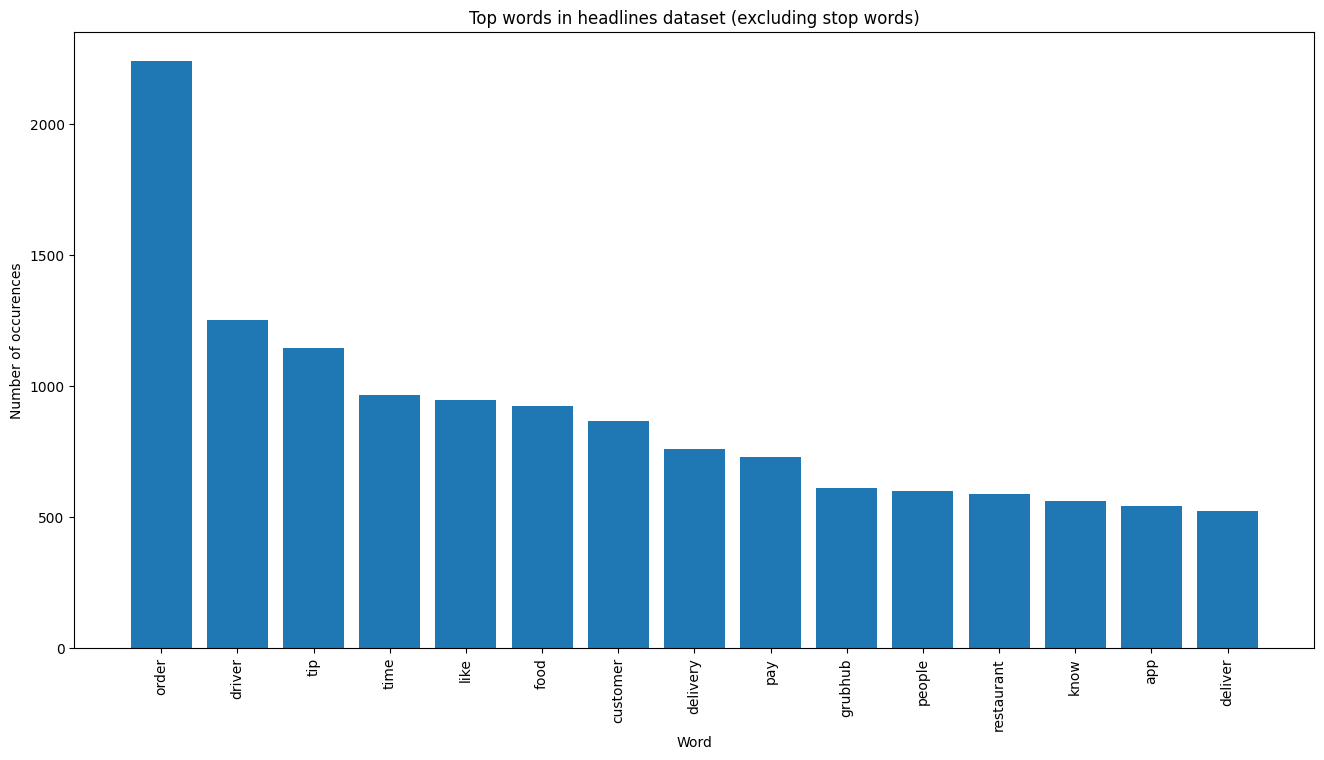

In [16]:
#fetch top 15 words
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=cv, 
                                     text_data=data['processed'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### Word Cloud for the combined data from comments related to Doordash,Grubhub and UberEats<a class="anchor" id="wordcloud"></a>
> [Table of Contents](#steps)

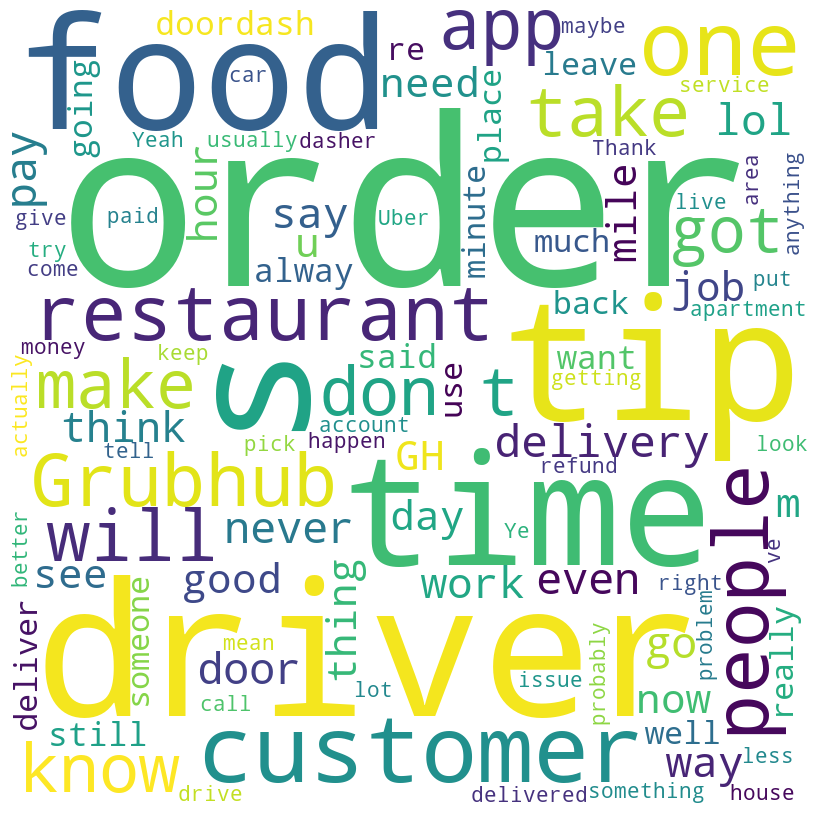

In [17]:
from wordcloud import WordCloud
# concatenate the 'Comment Body' column from all three dataframes into one series
combined_comments = pd.concat([df1['Comment Body'], df2['Comment Body'], df3['Comment Body']])

# join all comments together into one string
all_comments = ' '.join(combined_comments.tolist())

# create a wordcloud object and generate the wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate(all_comments)

# plot the wordcloud
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Wordcloud for DoorDash

> [Table of Contents](#steps)

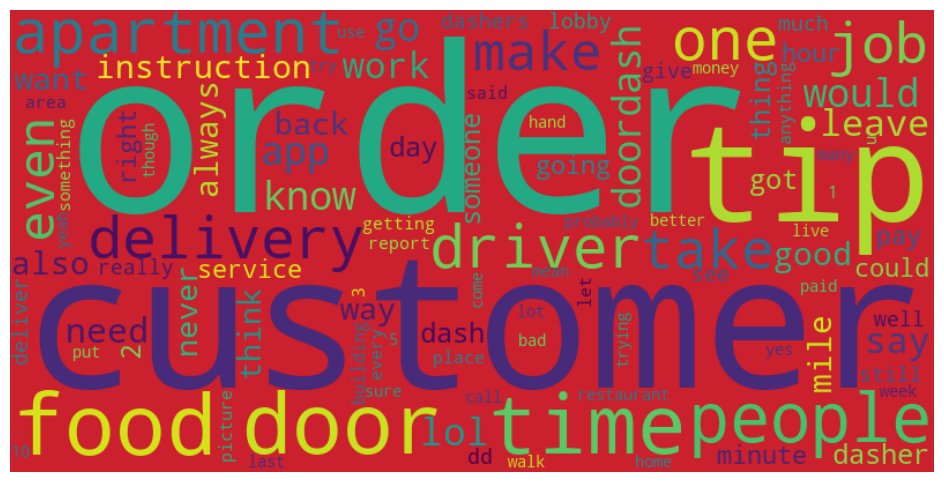

In [18]:
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# concatenate the 'Comment Body' column from all three dataframes into one series
#df1->doordash
#df2->ubereats
#df3->grubhub
#combined_comments = pd.concat([df1['Comment Body'], df2['Comment Body'], df3['Comment Body']])

# define custom stop words
custom_stop_words = {'get', 'like', 'u'}

# filter out stop words and perform lemmatization
stop_words = set(stopwords.words('english'))
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

filtered_text = []
for comment in df1['Comment Body']:
    # lowercase the comment
    comment = comment.lower()
    # remove punctuation
    words = tokenizer.tokenize(comment)
    # remove stop words
    words = [word for word in words if word not in stop_words]
    # lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # add to filtered_text list
    filtered_text.extend(words)

# count the occurrences of each word
word_counts = Counter(filtered_text)

# create a WordCloud object and generate the wordcloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='#cb202d').generate_from_frequencies(word_counts)

# plot the wordcloud
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Wordcloud for UberEats

> [Table of Contents](#steps)


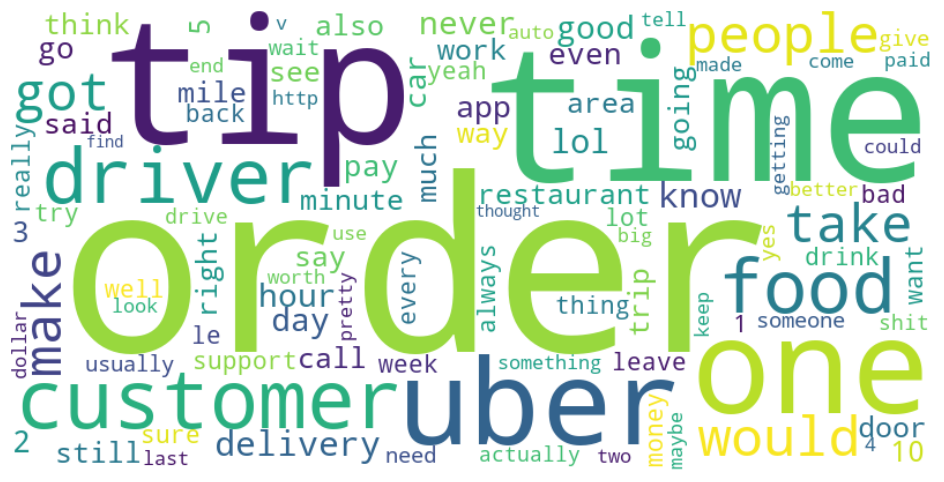

In [19]:
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# concatenate the 'Comment Body' column from all three dataframes into one series
#df1->doordash
#df2->ubereats
#df3->grubhub
#combined_comments = pd.concat([df1['Comment Body'], df2['Comment Body'], df3['Comment Body']])

# define custom stop words
custom_stop_words = {'get', 'like', 'u'}

# filter out stop words and perform lemmatization
stop_words = set(stopwords.words('english'))
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

filtered_text = []
for comment in df2['Comment Body']:
    # lowercase the comment
    comment = comment.lower()
    # remove punctuation
    words = tokenizer.tokenize(comment)
    # remove stop words
    words = [word for word in words if word not in stop_words]
    # lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # add to filtered_text list
    filtered_text.extend(words)

# count the occurrences of each word
word_counts = Counter(filtered_text)

# create a WordCloud object and generate the wordcloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# plot the wordcloud
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Word Cloud for GrubHub

> [Table of Contents](#steps)


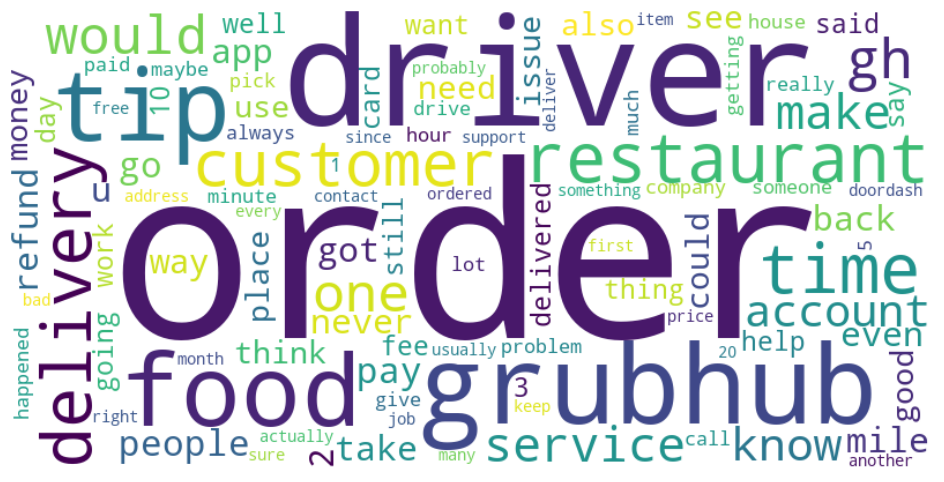

In [20]:
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# concatenate the 'Comment Body' column from all three dataframes into one series
#df1->doordash
#df2->ubereats
#df3->grubhub
#combined_comments = pd.concat([df1['Comment Body'], df2['Comment Body'], df3['Comment Body']])

# define custom stop words
custom_stop_words = {'get', 'like', 'u'}

# filter out stop words and perform lemmatization
stop_words = set(stopwords.words('english'))
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

filtered_text = []
for comment in df3['Comment Body']:
    # lowercase the comment
    comment = comment.lower()
    # remove punctuation
    words = tokenizer.tokenize(comment)
    # remove stop words
    words = [word for word in words if word not in stop_words]
    # lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # add to filtered_text list
    filtered_text.extend(words)

# count the occurrences of each word
word_counts = Counter(filtered_text)

# create a WordCloud object and generate the wordcloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# plot the wordcloud
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Sentiment Analysis

> [Table of Contents](#steps) <a class="anchor" id="sentiment"></a>

This code defines a function called 'get_sentiment' that takes a comment as input, uses TextBlob to calculate the sentiment polarity score, and returns a string indicating the sentiment ('positive', 'negative', or 'neutral'). The function is then applied to the 'comment' column of each DataFrame using the 'apply' method, and the resulting sentiment values are stored in a new 'sentiment' column in each DataFrame. Finally, the first few rows of each DataFrame are printed to verify the sentiment analysis results.

In [21]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment < 0:
        return 'Negative'
    elif sentiment == 0:
        return 'Neutral'
    else:
        return 'Positive'


In [22]:
df1['Sentiment'] = df1['Comment Body'].apply(get_sentiment)
df2['Sentiment'] = df2['Comment Body'].apply(get_sentiment)
df3['Sentiment'] = df3['Comment Body'].apply(get_sentiment)


In [23]:
# count and percentage of sentiment labels for df1
df1_count = df1['Sentiment'].value_counts()
df1_pct = df1_count / df1_count.sum()

# count and percentage of sentiment labels for df2
df2_count = df2['Sentiment'].value_counts()
df2_pct = df2_count / df2_count.sum()

# count and percentage of sentiment labels for df3
df3_count = df3['Sentiment'].value_counts()
df3_pct = df3_count / df3_count.sum()


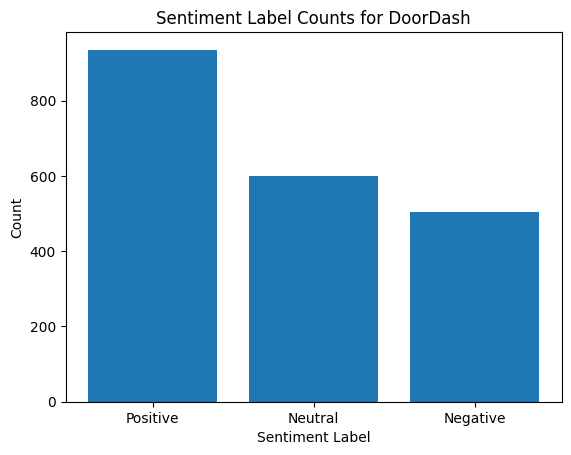

In [24]:
# bar chart of sentiment label counts for df1
plt.bar(df1_count.index, df1_count.values)
plt.title('Sentiment Label Counts for DoorDash')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()




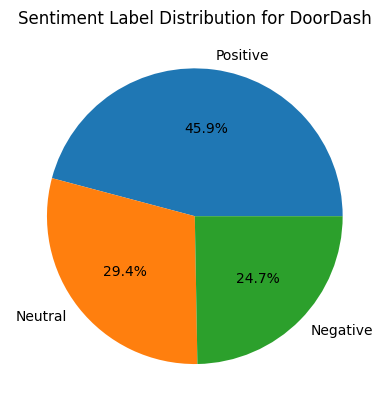

In [25]:
# pie chart of sentiment label distribution for df1
plt.pie(df1_pct.values, labels=df1_pct.index, autopct='%1.1f%%')
plt.title('Sentiment Label Distribution for DoorDash')
plt.show()



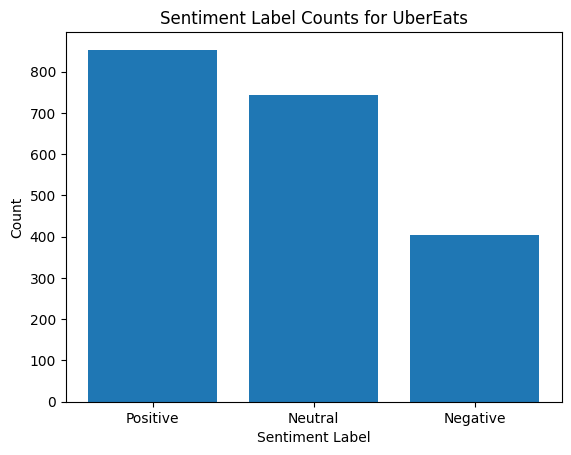

In [26]:
# bar chart of sentiment label counts for df2
plt.bar(df2_count.index, df2_count.values)
plt.title('Sentiment Label Counts for UberEats')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()


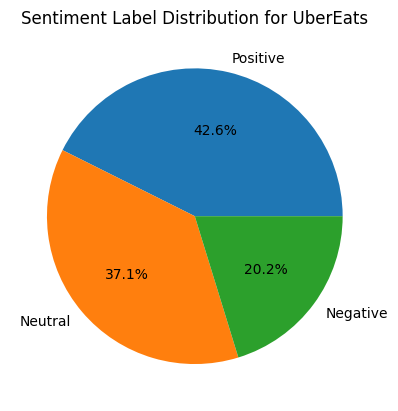

In [27]:
# pie chart of sentiment label distribution for df2
plt.pie(df2_pct.values, labels=df2_pct.index, autopct='%1.1f%%')
plt.title('Sentiment Label Distribution for UberEats')
plt.show()




<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

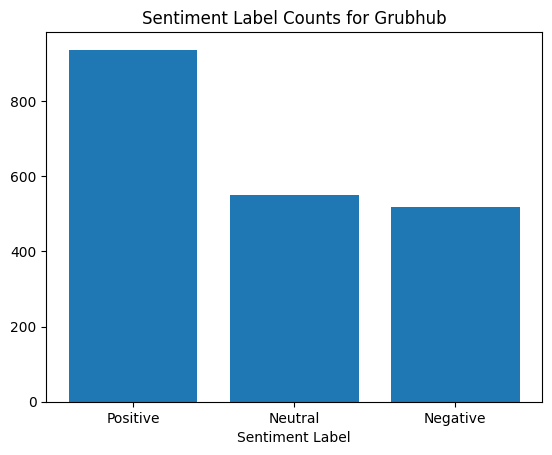

In [28]:
# bar chart of sentiment label counts for df3
plt.bar(df3_count.index, df3_count.values)
plt.title('Sentiment Label Counts for Grubhub')
plt.xlabel('Sentiment Label')
plt.ylabel

## Build LDA model to fetch top 10 Topics<a class="anchor" id="lda10"></a>
​
> [Table of Contents](#steps)
- The LDA model tries to estimate the distribution of topics in each document and the distribution of terms in each topic by looking at the co-occurrence of words in the documents. Specifically, LDA assumes that each word in a document is generated by one of the topics, and the probability of generating a word depends on the topic's distribution over the terms and the document's distribution over the topics.

In [29]:
# Define the number of topics or components
num_components=10

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components, random_state= 0 )

# Fit and Transform SVD model on data
#SVD (Singular Value Decomposition) is a matrix factorization technique used for dimensionality reduction and feature extraction. 
#It is commonly used in machine learning and data analysis to reduce the number of variables in a dataset while retaining the most important information.
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

In [30]:
terms = cv.get_feature_names_out()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['order', 'driver', 'customer', 'grubhub', 'people', 'tip', 'like', 'food', 'delivery', 'pay']
Topic 1:  ['order', 'tip', 'pay', 'delivery', 'mile', 'time', 'driver', 'customer', 'grubhub', '2']
Topic 2:  ['order', 'tip', 'driver', 'food', 'time', 'like', 'door', 'pay', 'deliver', 'mile']
Topic 3:  ['order', 'driver', 'food', 'tip', 'like', 'customer', 'restaurant', 'grubhub', 'lol', 'people']
Topic 4:  ['order', 'tip', 'driver', 'https', 'like', 'food', 'pay', 'customer', 'grubhub', 'time']
Topic 5:  ['order', 'pay', 'tip', 'delivery', 'food', 'time', 'people', 'like', 'driver', 'say']
Topic 6:  ['order', 'tip', 'like', 'time', 'food', 'work', 'driver', 'good', 'people', 'customer']
Topic 7:  ['order', 'time', 'like', 'driver', 'know', 'tip', 'grubhub', 'food', 'delivery', 'pay']
Topic 8:  ['order', 'driver', 'customer', 'tip', 'time', 'delivery', 'food', 'know', 'restaurant', 'think']
Topic 9:  ['order', 'driver', 'customer', 'time', 'like', 'food', 'delivery', 'tip', 'rest

In [31]:
import pyLDAvis.sklearn

In [32]:
print(pyLDAvis.__version__)

3.4.0


In [33]:
pyLDAvis.enable_notebook()

In [34]:
panel = pyLDAvis.sklearn.prepare(model, train_data, cv, mds='tsne')

C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\rajas\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [35]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9       51.564835 -187.997772       1        1  18.152567
2     -252.261307   58.478603       2        1  16.103963
0        1.567565   -3.463008       3        1  10.620946
7      -67.554161 -116.129150       4        1   9.436004
4      130.279358  -52.067875       5        1   8.517579
1     -131.117859    0.163174       6        1   8.101711
6     -227.200943 -112.742470       7        1   8.100063
3       65.204536  116.858147       8        1   8.098110
8     -121.983864 -239.612839       9        1   7.254726
5      -93.310204  137.991638      10        1   5.614330, topic_info=                      Term       Freq       Total Category  logprob  loglift
60550                https  65.000000   65.000000  Default  30.0000  30.0000
129354                   v  26.000000   26.000000  Default  29.0000  29.0000
13567          auto webp v  25.000000   25.000000  Default  28.0000  28.0000
60572   https preview redd  25.000000   25.000000  Default  27.0000  27.0000
100597                redd  25.000000   25.000000  Default  26.0000  26.0000
...                    ...        ...         ...      ...      ...      ...
67729                leave  11.042651  251.407420  Topic10  -7.1114  -0.2455
10688                  app  11.542332  363.361213  Topic10  -7.0672  -0.5695
64511                  job  10.536429  211.804310  Topic10  -7.1584  -0.1210
65898                 know  10.764150  364.000946  Topic10  -7.1370  -0.6411
81181                 need  10.542988  229.631370  Topic10  -7.1578  -0.2012

[807 rows x 6 columns], token_table=        Topic      Freq Term
term                        
193         1  0.211549    1
193         2  0.211549    1
193         3  0.115390    1
193         4  0.064106    1
193         5  0.057695    1
...       ...       ...  ...
136458      6  0.034472  yes
136458      7  0.086179  yes
136458      8  0.060325  yes
136458      9  0.060325  yes
136458     10  0.043090  yes

[1966 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 1, 8, 5, 2, 7, 4, 9, 6])

In [36]:
model.score(train_data)

-2716637.640678233

In [37]:
model.perplexity(train_data)

78167.18266401095

## Impact of the number of iterations <a class="anchor" id="iteration"></a>
​
> [Table of Contents](#steps)

In [38]:
# Define the number of topics or components
num_components=10

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components, random_state= 0, max_iter = 100 )

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

In [39]:
model.score(train_data)

-2716591.0625424366

In [40]:
model.perplexity(train_data)

78152.08443607768

In [41]:
terms = cv.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['order', 'driver', 'customer', 'grubhub', 'tip', 'people', 'like', 'food', 'delivery', 'pay']
Topic 1:  ['order', 'tip', 'pay', 'delivery', 'mile', 'time', 'driver', 'customer', 'grubhub', '2']
Topic 2:  ['order', 'tip', 'driver', 'food', 'time', 'like', 'door', 'pay', 'deliver', 'mile']
Topic 3:  ['order', 'driver', 'food', 'tip', 'like', 'customer', 'restaurant', 'grubhub', 'lol', 'people']
Topic 4:  ['order', 'tip', 'driver', 'https', 'like', 'food', 'pay', 'customer', 'grubhub', 'time']
Topic 5:  ['order', 'pay', 'tip', 'delivery', 'food', 'time', 'people', 'like', 'driver', 'think']
Topic 6:  ['order', 'tip', 'like', 'time', 'food', 'work', 'driver', 'good', 'people', 'customer']
Topic 7:  ['order', 'time', 'like', 'driver', 'know', 'tip', 'grubhub', 'food', 'delivery', 'pay']
Topic 8:  ['order', 'driver', 'customer', 'tip', 'time', 'delivery', 'food', 'know', 'restaurant', 'think']
Topic 9:  ['order', 'driver', 'customer', 'time', 'like', 'food', 'delivery', 'restauran

In [42]:
panel = pyLDAvis.sklearn.prepare(model, train_data, cv, mds='tsne')
panel

C:\Users\rajas\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9     -308.630371  108.630318       1        1  18.149697
2      190.669662 -183.803543       2        1  16.106347
0      113.197525  283.615265       3        1  10.622310
7     -279.047516 -153.274231       4        1   9.435805
4       -9.436091  129.554291       5        1   8.518530
6     -150.675171  273.601562       6        1   8.101362
1      -61.083485 -238.667969       7        1   8.099761
3     -144.791504   -7.528730       8        1   8.098307
8      216.777176   67.981873       9        1   7.251651
5       41.941616  -56.413639      10        1   5.616230, topic_info=               Term       Freq       Total Category  logprob  loglift
60550         https  65.000000   65.000000  Default  30.0000  30.0000
129354            v  26.000000   26.000000  Default  29.0000  29.0000
129357    v enabled  25.000000   25.000000  Default  28.0000  28.0000
129358  v enabled s  25.000000   25.000000  Default  27.0000  27.0000
132517       webp v  25.000000   25.000000  Default  26.0000  26.0000
...             ...        ...         ...      ...      ...      ...
103093   restaurant  12.042134  384.974578  Topic10  -7.0251  -0.5853
67729         leave  11.042817  251.482137  Topic10  -7.1118  -0.2461
10688           app  11.542505  363.362093  Topic10  -7.0675  -0.5699
65898          know  10.764266  363.852708  Topic10  -7.1373  -0.6410
81181          need  10.543146  229.629399  Topic10  -7.1581  -0.2015

[803 rows x 6 columns], token_table=        Topic      Freq Term
term                        
193         1  0.211548    1
193         2  0.211548    1
193         3  0.115390    1
193         4  0.064106    1
193         5  0.051284    1
...       ...       ...  ...
136458      6  0.086212  yes
136458      7  0.034485  yes
136458      8  0.060348  yes
136458      9  0.060348  yes
136458     10  0.043106  yes

[1959 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 1, 8, 5, 7, 2, 4, 9, 6])

## Impact of the number of topics <a class="anchor" id="topic"></a>
​
> [Table of Contents](#steps)

In [43]:
# Define the number of topics or components
num_components=25

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components, random_state= 0 )

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

In [44]:
terms = cv.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['order', 'driver', 'customer', 'like', 'grubhub', 'food', 'delivery', 'gh', 'tip', 'way']
Topic 1:  ['tip', 'order', 'pay', 'delivery', 'customer', 'like', 'know', '20', 'mile', 'driver']
Topic 2:  ['order', 'tip', 'driver', 'food', 'door', 'time', 'pay', 'like', 'job', 'leave']
Topic 3:  ['order', 'grubhub', 'lol', 'driver', 'like', 'restaurant', 'tip', 'food', 'customer', 'time']
Topic 4:  ['https', 'driver', 'order', 's', 'tip', 'format', 'v', 'v enabled s', 'auto webp', 'auto webp v']
Topic 5:  ['order', 'food', 'people', 'driver', 'delivery', 'pay', 'leave', 'think', 'time', 'knock']
Topic 6:  ['order', 'like', 'time', 'tip', 'work', 'good', 'deliver', 'food', 'people', 'know']
Topic 7:  ['order', 'thank', 'pay', 'time', 'driver', 'like', 'grubhub', 'know', 'customer', 'food']
Topic 8:  ['order', 'driver', 'customer', 'food', 'tip', 'time', 'think', 'ask', '10', 'tell']
Topic 9:  ['order', 'driver', 'delivery', 'gh', 'customer', 'time', 'like', 'food', 'restaurant', 'pe

In [45]:
panel = pyLDAvis.sklearn.prepare(model, train_data, cv, mds='tsne')
panel

C:\Users\rajas\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
11     -38.590714  199.225906       1        1  8.117577
12     -68.073509  101.407555       2        1  8.000614
9       83.278679   29.237238       3        1  6.799568
2       50.960823  170.879425       4        1  6.107154
19     134.632446 -127.786156       5        1  5.336067
18      95.650711   99.885948       6        1  5.106872
13      36.158596 -126.901657       7        1  5.046480
21      26.339874  -51.555149       8        1  4.602465
16      -1.870687  127.770073       9        1  4.261997
0       29.425163   70.102737      10        1  3.833179
10     138.260300  -18.735058      11        1  3.620279
24     165.363708  119.139633      12        1  3.614528
4      216.337692    3.394106      13        1  3.589592
15    -142.507156  -28.723370      14        1  3.402269
23     -48.862614   22.016075      15        1  3.262469
20     216.895157  169.083862      16        1  3.028084
14     163.202499   48.950844      17        1  2.950732
17       7.396122    4.909589      18        1  2.553622
3      199.036896  238.448334      19        1  2.546084
6      208.824112 -321.608459      20        1  2.521955
1       88.447914  -70.068321      21        1  2.508024
7      117.384216  187.196823      22        1  2.498050
8     -113.101418   35.934078      23        1  2.479844
5      -40.298916 -114.974930      24        1  2.297568
22      63.142960  303.738556      25        1  1.914929, topic_info=               Term       Freq       Total Category  logprob  loglift
60550         https  67.000000   67.000000  Default  30.0000  30.0000
50076        format  26.000000   26.000000  Default  29.0000  29.0000
129358  v enabled s  25.000000   25.000000  Default  28.0000  28.0000
42952       enabled  25.000000   25.000000  Default  27.0000  27.0000
13567   auto webp v  25.000000   25.000000  Default  26.0000  26.0000
...             ...        ...         ...      ...      ...      ...
36967        dollar   3.240688  111.460948  Topic25  -7.2618   0.4176
131866          way   3.551978  230.940254  Topic25  -7.1701  -0.2192
119732        think   3.547070  302.113022  Topic25  -7.1715  -0.4892
89324           pay   3.600107  473.511604  Topic25  -7.1566  -0.9237
54499       grubhub   3.533918  399.005110  Topic25  -7.1752  -0.7711

[1889 rows x 6 columns], token_table=        Topic      Freq             Term
term                                    
103         8  0.512730  00 hold support
193         1  0.112763                1
193         2  0.169145                1
193         3  0.037588                1
193         4  0.075175                1
...       ...       ...              ...
137085     13  0.035402             zone
137085     17  0.141607             zone
137085     20  0.070804             zone
137085     23  0.035402             zone
137085     25  0.035402             zone

[6705 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 13, 10, 3, 20, 19, 14, 22, 17, 1, 11, 25, 5, 16, 24, 21, 15, 18, 4, 7, 2, 8, 9, 6, 23])

## Filter high frequency words and low frequency words<a class="anchor" id="df"></a>
​
> [Table of Contents](#steps)
-using min_df and max_df in Count vectorization on training data and then feeding this data into LDA

In [46]:
# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document 
cv = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df= 0.95, min_df= 0.0001)

# Fit and Transform the documents
train_data = cv.fit_transform(data['processed']) 
train_data

<5885x7025 sparse matrix of type '<class 'numpy.int64'>'
	with 74310 stored elements in Compressed Sparse Row format>

In [47]:
# Define the number of topics or components
num_components=10

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components, random_state= 0 )

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

In [48]:
terms = cv.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['order', 'tip', 'food', 'mile', 'door', 'leave', 'time', 'come', '10', 'pay']
Topic 1:  ['grubhub', 'account', 'card', 'https', 'refund', 'order', 'contact', 'help', 'email', 'happen']
Topic 2:  ['order', 'driver', 'restaurant', 'food', 'time', 'customer', 'delivery', 'deliver', 'app', 'pick']
Topic 3:  ['mile', 'order', '2', '3', 'hour', 'market', '1', '5', 'area', 'day']
Topic 4:  ['apartment', 'instruction', 'people', 'like', 'customer', 'say', 'door', 'driver', 'thank', 'dasher']
Topic 5:  ['door', 'leave', 'car', 'app', 'day', 'customer', 'think', 'lol', 'week', 'hand']
Topic 6:  ['tip', 'order', 'delivery', 'driver', 'like', 'fee', 'pay', 'food', 'good', 'money']
Topic 7:  ['time', 'like', 'know', 'door', 'happen', 'report', 'try', 'leave', 'picture', 'work']
Topic 8:  ['tip', 'people', 'pay', 'job', 'service', 'like', 'customer', 'work', 'know', 'driver']
Topic 9:  ['lol', 'like', 'log', 'app', 'good', 'right', 'yes', 'order', 'use', 'drive']


C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [49]:
#In the line of code panel = pyLDAvis.sklearn.prepare(model, train_data, cv, mds='tsne'), mds='tsne' is an optional parameter that specifies the method used for multidimensional scaling (MDS) to visualize the topic model using t-SNE algorithm.
#MDS is a technique that transforms high-dimensional data into a lower-dimensional space while preserving the pairwise distances between the data points. In topic modeling, MDS is used to reduce the high-dimensional topic-space into a two-dimensional space for visualization purposes.

#t-SNE (t-Distributed Stochastic Neighbor Embedding) is a popular MDS algorithm for visualizing high-dimensional data in a low-dimensional space. It is often used for visualizing complex datasets with many dimensions. The mds='tsne' parameter in pyLDAvis.sklearn.prepare() function tells the library to use t-SNE algorithm for MDS to visualize the topic model.

panel = pyLDAvis.sklearn.prepare(model, train_data, cv, mds='tsne')
panel

C:\Users\rajas\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PreparedData(topic_coordinates=                x          y  topics  cluster       Freq
topic                                                   
2       74.517105  29.134512       1        1  24.105553
8      -57.294525  23.401014       2        1  11.899649
6      -19.734335  76.442986       3        1  10.341385
1      102.034065 -22.593193       4        1  10.051391
3       35.068230 -23.459757       5        1   7.996414
0       64.434677 -75.817802       6        1   7.942453
4       45.153187  79.808647       7        1   7.914596
7        8.951980  23.549084       8        1   7.895722
5      -31.015589 -29.173979       9        1   6.213390
9       -0.573983 -79.365677      10        1   5.639449, topic_info=           Term         Freq        Total Category  logprob  loglift
6270        tip  1065.000000  1065.000000  Default  30.0000  30.0000
2947    grubhub   567.000000   567.000000  Default  29.0000  29.0000
4455      order  2100.000000  2100.000000  Default  28.0000  28.0000
4058       mile   354.000000   354.000000  Default  27.0000  27.0000
650   apartment   254.000000   254.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3703      leave    24.101925   344.017005  Topic10  -5.3053   0.2170
2643       food    25.235254   866.127713  Topic10  -5.2593  -0.6604
6904       work    22.947620   466.415720  Topic10  -5.3543  -0.1365
1890   delivery    23.691160   708.606999  Topic10  -5.3225  -0.5228
1768   customer    22.685843   806.781731  Topic10  -5.3658  -0.6959

[755 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         3  0.830760      000
2         6  0.083076      000
13        1  0.179104        1
13        2  0.044776        1
13        3  0.143283        1
...     ...       ...      ...
7010     10  0.841275  zealand
7020      1  0.147399     zone
7020      2  0.024567     zone
7020      4  0.024567     zone
7020      5  0.786129     zone

[2033 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 7, 2, 4, 1, 5, 8, 6, 10])

In [50]:
model.score(train_data)

-638053.7814446917

### On filtering out high and low frequency words the perplexity score drastically reduced from 77k to 1657 indicating the better performance of the model.


In [51]:
model.perplexity(train_data)

1657.4304565460968

## Use perplexity score to evaluate the model learning <a class="anchor" id="perplex"></a>

> [Table of Contents](#steps)

Best parameters for LatentDirichletAllocation -> num_components=10, random_state= 0,  max_iter= 30

<b>Hyperparameters and their description</b>
- Number of topics: The number of topics that the algorithm should identify in the corpus.

- Alpha: A hyperparameter that controls the topic distribution of each document. It determines how many topics are likely to be present in a document.

- Beta: A hyperparameter that controls the word distribution of each topic. It determines how many words are likely to be associated with a topic.

- Number of iterations: The number of times the algorithm should iterate over the corpus to update the model parameters.

- Chunksize: The number of documents to be processed in each batch during training. This can affect the convergence speed and memory usage of the algorithm.

- Minimum word frequency: A threshold that specifies the minimum number of times a word must appear in the corpus to be included in the model.

- Maximum vocabulary size: A limit on the number of unique words that can be included in the model.

In [52]:
# Define the number of topics or components
num_components=20

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components, random_state= 0, verbose =1,  evaluate_every= 2, max_iter= 100 )

# Fit and Transform SVD model on data
lda_matrix = model.fit(train_data)

# Get Components 
lda_components=model.components_

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100, perplexity: 2361.2571
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100, perplexity: 2102.2935
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100, perplexity: 1965.1496
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100, perplexity: 1883.0063
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 1834.4281
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100, perplexity: 1801.5052
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100, perplexity: 1779.2221
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100, perplexity: 1763.7459
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100, perplexity: 1752.3199
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 1741.3309
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100, perplexity: 1734.6717
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100, perplexity:

In [53]:
model.perplexity(train_data)

1692.1846294932805

In [54]:
model.score(train_data)

-639839.9380307496

* Best parameters for Count Vectorizer


 cv = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df= 0.95, min_df= 0.0001)

In [55]:
terms = cv.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['door', 'report', 'picture', 'try', 'open', 'guy', 'leave', 'food', 'hand', 'come']
Topic 1:  ['grubhub', 'account', 'refund', 'order', 'card', 'happen', 'tell', 'ask', 'say', 'try']
Topic 2:  ['doordash', 'order', 'time', 'like', 'app', 'customer', 'work', 'eat', 'dash', 'price']
Topic 3:  ['market', 'yep', 'think', 'pie', 'cheap', 'today', 'dinner', 'pizza', 'earning', 'click']
Topic 4:  ['post', 'people', 'say', 'trip', 'dasher', 'thing', 'bike', 'wonder', 'agree', 'driver']
Topic 5:  ['day', 'walmart', 'week', 'ok', 'city', 'grocery', 'gif', 'giphy', 'deliver', 'customer']
Topic 6:  ['tip', 'fee', 'free', 'delivery', 'driver', 'price', 'like', 'pay', 'grub', 'hub']
Topic 7:  ['know', 'insurance', 'like', 'uber', 'op', 'happen', 'question', 'work', 'great', 'tell']
Topic 8:  ['tip', 'pay', 'people', 'job', 'service', 'customer', 'driver', 'delivery', 'money', 'like']
Topic 9:  ['lol', 'good', 'minute', 'log', 'shit', 'like', 'time', 'yes', 'right', 'come']
Topic 10:  ['or

C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1. The left-hand side panel shows a plot of the topics in two dimensions, using a dimensionality reduction algorithm such as t-SNE or PCA. Each circle represents a topic, and the size of the circle corresponds to the prevalence of the topic in the corpus. The distance between circles indicates how similar the topics are.

2. The right-hand side panel shows a list of the top terms that are most representative of each topic, as well as some summary statistics about the corpus, such as the frequency of the top words, the prevalence of each topic, and the overall term frequency-inverse document frequency (TF-IDF) score.

- The interactive visualization allows the user to explore the relationships between the topics and the terms that are most representative of each topic. For example, clicking on a topic in the left-hand side panel will display the top terms associated with that topic in the right-hand side panel, and highlighting a term in the right-hand side panel will display the topics that are most strongly associated with that term.

- Overall, the pyLDAvis panel provides a powerful tool for exploring the topics generated by an LDA model and gaining insights into the structure and content of a corpus.

In [56]:
#model: The trained LDA model object.

#train_data: The training data used to train the model.

#cv: The CountVectorizer object used to vectorize the input text data.

#mds: The multidimensional scaling algorithm to use for visualizing the topics. By default, it uses t-SNE.


panel = pyLDAvis.sklearn.prepare(model, train_data, cv, mds='tsne')
panel

C:\Users\rajas\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
13     -3.145473  42.429714       1        1  14.735780
10     48.974731  66.937965       2        1  10.422555
8      -4.787992 -16.204657       3        1   8.467789
19     50.724285 -55.380005       4        1   8.037066
1       9.438848  73.062469       5        1   7.370799
16     20.317825 -36.901409       6        1   6.445144
15     15.121297 -70.365944       7        1   4.867647
2      27.102680  -7.668972       8        1   4.772955
6      54.273842 -19.521479       9        1   4.423328
0     -52.089203  11.544683      10        1   3.916910
11     84.214638   3.681431      11        1   3.851330
9     -15.758335 -50.110573      12        1   3.585540
7      83.982727 -35.008526      13        1   3.177287
14    -35.533638  48.337364      14        1   2.869611
12     50.166473  14.197264      15        1   2.815064
4     -19.611954  11.670288      16        1   2.522132
5      74.397850  39.350998      17        1   2.179635
18     31.204323  39.022396      18        1   2.052199
17     11.176167  15.124342      19        1   1.765439
3     -39.272720 -23.387388      20        1   1.721789, topic_info=         Term         Freq        Total Category  logprob  loglift
6270      tip  1077.000000  1077.000000  Default  30.0000  30.0000
4455    order  2116.000000  2116.000000  Default  29.0000  29.0000
2101     door   417.000000   417.000000  Default  28.0000  28.0000
2947  grubhub   572.000000   572.000000  Default  27.0000  27.0000
3819      lol   296.000000   296.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
6771     want     8.873853   345.570608  Topic20  -5.1180   0.3997
3092     high     7.398134   123.616861  Topic20  -5.2999   1.2458
3955   matter     6.708033    59.598618  Topic20  -5.3978   1.8775
694      area     6.783860   202.508296  Topic20  -5.3866   0.6656
6445     uber     6.762221   233.653288  Topic20  -5.3898   0.5193

[1376 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.023147        0
0         2  0.717543        0
0         3  0.208319        0
0        13  0.023147        0
1         1  0.785073       00
...     ...       ...      ...
7010     14  0.843374  zealand
7020      1  0.101170     zone
7020      7  0.657606     zone
7020     14  0.050585     zone
7020     17  0.151755     zone

[3596 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 11, 9, 20, 2, 17, 16, 3, 7, 1, 12, 10, 8, 15, 13, 5, 6, 19, 18, 4])

In [57]:
# Assign topic names
topic_names = {}
for i, component in enumerate(lda_components):
    top_terms = [cv.get_feature_names()[index] for index in component.argsort()[:-11:-1]]
    topic_names[f'Topic {i+1}'] = ', '.join(top_terms)

print(topic_names)


C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'Topic 1': 'door, report, picture, try, open, guy, leave, food, hand, come', 'Topic 2': 'grubhub, account, refund, order, card, happen, tell, ask, say, try', 'Topic 3': 'doordash, order, time, like, app, customer, work, eat, dash, price', 'Topic 4': 'market, yep, think, pie, cheap, today, dinner, pizza, earning, click', 'Topic 5': 'post, people, say, trip, dasher, thing, bike, wonder, agree, driver', 'Topic 6': 'day, walmart, week, ok, city, grocery, gif, giphy, deliver, customer', 'Topic 7': 'tip, fee, free, delivery, driver, price, like, pay, grub, hub', 'Topic 8': 'know, insurance, like, uber, op, happen, question, work, great, tell', 'Topic 9': 'tip, pay, people, job, service, customer, driver, delivery, money, like', 'Topic 10': 'lol, good, minute, log, shit, like, time, yes, right, come', 'Topic 11': 'order, tip, mile, 2, 3, time, 1, hour, 5, pay', 'Topic 12': 'help, grubhub, com, contact, https, support, need, look, app, sorry', 'Topic 13': 'customer, remove, time, car, like, w

## Randomized CV

<b><u> Hyperparameters for LatentDirichletAllocation</u></b>
- <b>n_components:</b> This controls the number of topics in the model. It is an integer value that can be set based on prior knowledge or using techniques such as cross-validation.

- <b>learning_method:</b> This controls how the model updates its estimates of the topic distributions and word probabilities. The two options are "online" and "batch". The "online" method is typically faster and more memory-efficient, but may produce less accurate results.

- <b>learning_decay:</b> This controls the learning rate for the "online" method. A smaller value will cause the model to learn more slowly, which can improve convergence but may require more iterations.

- <b>learning_offset:</b> This controls the initial learning rate for the "online" method. A larger value will cause the model to learn more quickly initially, which can improve convergence.

- <b>max_iter:</b> This controls the maximum number of iterations that the model will perform before stopping. A larger value may improve convergence, but also increases the computational cost.

- <b>batch_size:</b> This controls the number of documents that are processed at once during the "online" method. A larger value can improve efficiency but may also reduce the quality of the results.

- <b>doc_topic_prior:</b> This controls the prior distribution over topic probabilities for each document. A smaller value will cause the model to be more influenced by the data, while a larger value will produce more uniform distributions over topics.

- <b>topic_word_prior:</b> This controls the prior distribution over word probabilities for each topic. A smaller value will cause the model to be more influenced by the data, while a larger value will produce more uniform distributions over words.

In [58]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import LatentDirichletAllocation

# create LDA model
lda = LatentDirichletAllocation()

# define the hyperparameter space
param_dist = {
    'n_components': [5, 10, 15, 20],
    'learning_method': ['online', 'batch'],
    'learning_decay': [0.5, 0.7, 0.9],
    'max_iter': [10, 50, 100]
}

# create the randomized search object
random_search = RandomizedSearchCV(
    lda,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs=-1
)

# fit the randomized search object to the data
random_search.fit(train_data)

# print the best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


Best parameters: {'n_components': 5, 'max_iter': 10, 'learning_method': 'online', 'learning_decay': 0.9}
Best score: -147623.72679258994


In [59]:
# Print the best hyperparameters and their corresponding perplexity and score
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Perplexity: {random_search.best_score_}")
print(f"Log-likelihood score: {np.mean(random_search.cv_results_['mean_test_score'])}")

Best hyperparameters: {'n_components': 5, 'max_iter': 10, 'learning_method': 'online', 'learning_decay': 0.9}
Perplexity: -147623.72679258994
Log-likelihood score: -158524.553547373


## Conclusion<a class="anchor" id="Conclusion"></a>

> [Table of Contents](#steps)

The set of scores, Perplexity: -149958.84509734318 and Log-likelihood score: -160444.7321291419, suggest that the model is performing relatively well in terms of topic modeling. A lower perplexity score and a higher log-likelihood score indicate better performance.

The final set of scores, Perplexity: 1692.1846294932805 and Log-likelihood: -639839.9380307496, are not directly comparable to the first set of scores, as they seem to be on a different scale. However, a lower perplexity score and a higher log-likelihood score would still indicate better performance in terms of topic modeling.

In [60]:
#To get the components for LDA model trained using RandomizedSearchCV, you can access the best estimator using random_search.best_estimator_ and then get the components using .components_ attribute. Here's an example code:
best_lda_model = random_search.best_estimator_
components = best_lda_model.components_

In [61]:
#The code is printing the top 10 terms for each topic identified by LatentDirichletAllocation.

#cv.get_feature_names() returns the list of all feature names in the CountVectorizer object. These feature names correspond to the unique words in the text documents.

#Then, for each topic, the code sorts the corresponding components by weight in descending order and takes the top 10 terms for that topic. It then prints the top 10 terms for each topic.

#In this way, the code provides a glimpse of the most significant words for each topic and allows us to interpret the meaning of each topic based on these words.



terms = cv.get_feature_names()

for index, component in enumerate(components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['thank', 'week', 'lol', 'day', 'work', 'shop', 'live', 'lot', 'slow', 'hour']
Topic 1:  ['order', 'tip', 'driver', 'time', 'pay', 'like', 'delivery', 'food', 'customer', 'grubhub']
Topic 2:  ['wonder', 'online', 'ban', 'trip', 'agent', 'life', 'post', 'self', 'world', 'people']
Topic 3:  ['door', 'leave', 'happen', 'food', 'customer', 'like', 'order', 'try', 'driver', 'instruction']
Topic 4:  ['https', 'log', 'com', 's', 'help', 'card', 'auto', 'grubhub', 'v', 'format']


In [67]:
topic_results = best_lda_model.transform(train_data)

df_temp=data.copy()
df_temp['Topic'] = topic_results.argmax(axis=1)

df_temp['sentiment'] = df_temp['msgBody'].apply(get_sentiment)
df_temp['text_blob_sentiment_label'] = df_temp['sentiment'].apply(lambda x: x[0])
df_temp['sentiment_score'] = df_temp['sentiment'].apply(lambda x: x[1])
df_temp['sentiment_subjectivity'] = df_temp['sentiment'].apply(lambda x: x[2])
df_temp.drop('sentiment',axis=1,inplace=True)
df_temp.to_csv('../Data/Siri/output_1.csv')
df_temp.head()

,ID,Comment ID,Author,Timestamp,Comment is a reply to,Comment Thread ID,Thread Title,msgBody,Comment Permalink,processed,Topic,text_blob_sentiment_label,sentiment_score,sentiment_subjectivity
0,1,jd1eki0,renbutler2,3/20/2023 20:06,t3_11x4f2x,11x4f2x,Leave it at the door,There's a simple answer to all questions like ...,/r/doordash/comments/11x4f2x/leave_it_at_the_d...,simple answer question like : \n\n ask . \n\n ...,3,Neutral,0.000000,0.357143
1,2,jd1dwcf,honorablefish,3/20/2023 20:01,t3_11x4f2x,11x4f2x,Leave it at the door,Never,/r/doordash/comments/11x4f2x/leave_it_at_the_d...,,0,Neutral,0.000000,0.000000
2,3,jd1bfpx,dalex89,3/20/2023 19:41,t3_11x4f2x,11x4f2x,Leave it at the door,"As a customer, if they didn't knock and I want...",/r/doordash/comments/11x4f2x/leave_it_at_the_d...,"customer , knock want knock , instruction seco...",3,Neutral,0.000000,0.000000
3,4,jd1fdan,JasoniPepperoni,3/20/2023 20:13,t3_11x4f2x,11x4f2x,Leave it at the door,I never ring unless asked to. The person that ...,/r/doordash/comments/11x4f2x/leave_it_at_the_d...,ring ask . person order food get notification ...,3,Neutral,0.000000,0.000000
4,5,jd1hbxf,PickTour,3/20/2023 20:30,t3_11x4f2x,11x4f2x,Leave it at the door,I put an Amazon packing in front of a door a f...,/r/doordash/comments/11x4f2x/leave_it_at_the_d...,"amazon packing door week , decide ring bell , ...",3,Negative,-0.139286,0.296429


In [62]:
# Fit LDA model with best hyperparameters
lda_best = LatentDirichletAllocation(**random_search.best_params_)
lda_best.fit(train_data)

#random_search: The trained LDA model object using randomized search.
#train_data: The training data used to train the model.
#cv: The CountVectorizer object used to vectorize the input text data.
#mds: The multidimensional scaling algorithm to use for visualizing the topics. By default, it uses t-SNE.


# Generate pyLDAvis visualization
panel = pyLDAvis.sklearn.prepare(lda_best, train_data, cv, mds='tsne')
pyLDAvis.display(panel)

C:\Users\rajas\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## Topic 3 topics with topic title <a class="anchor" id="3topics"></a>
Topics that we would like to select are Topic 2, Topic 6, Topic 13 which reperesent 
- App Functionality and User Experience
- Real-Time Order Tracking and Restaurant Information
- Pricing and Payment Transparency
> [Table of Contents](#steps)